In [1]:
import pandas as pd
import numpy as np
np.random.seed(1234)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
df = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(4857377, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Text(0.5, 1.0, 'Feature Correlation Plot')

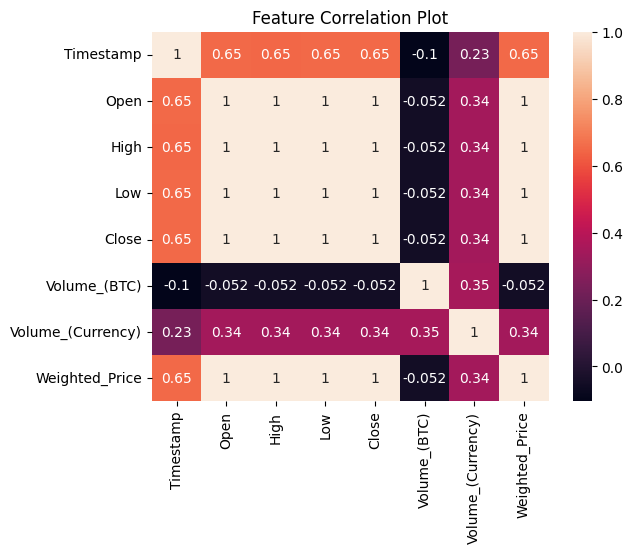

In [5]:
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Plot")

Text(0.5, 1.0, 'BitCoin Price Dynamics')

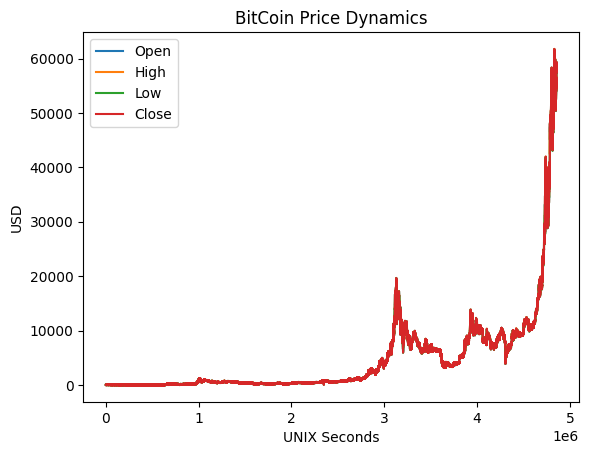

In [6]:
ax = df["Open"].plot(legend=True)
df["High"].plot(axes=ax, legend=True)
df["Low"].plot(axes=ax, legend=True)
df["Close"].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Dynamics")

In [7]:
num = 50
start = int(1e6)
finish = start+num

Text(0.5, 1.0, 'BitCoin Price Dynamics')

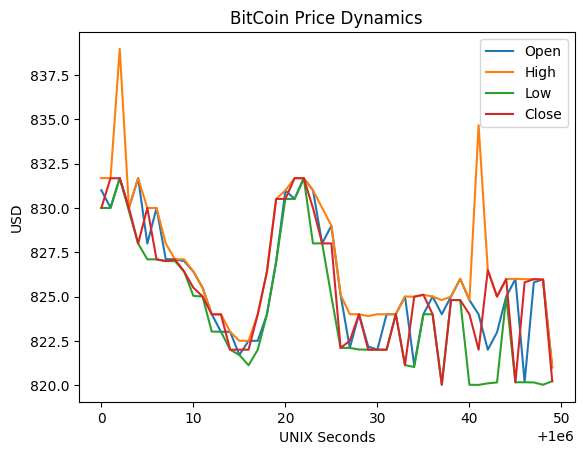

In [8]:
ax = df["Open"][start:finish].plot(legend=True)
df["High"][start:finish].plot(axes=ax, legend=True)
df["Low"][start:finish].plot(axes=ax, legend=True)
df["Close"][start:finish].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Dynamics")

Text(0.5, 1.0, 'BitCoin Price Fractional Change Dynamics')

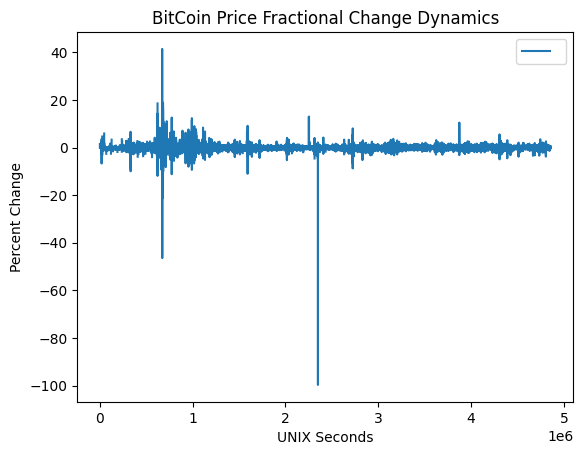

In [9]:
ax = (100*(df["Close"] - df["Open"])/df["Open"]).plot(legend=True)
ax.set_ylabel("Percent Change")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Fractional Change Dynamics")

BELOW FOR HMMs

In [10]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.2, 0.7, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(20)

In [11]:
# First, we will remove outlier rows where fractional open to close price exceeds 20% as this only appears to 
# occur three times in the 10 years of minute-date
df_reduced = df.drop(df[((df['Close']-df['Open'])/df['Open']).abs() > 0.2].index)
# The following will remove all time windows in which trading did not occur. 
# In order to note forget these windows, 'Timestamp' is replaced by 'TimeDelta' 
# which represents time since last trade. We posit that this is a valid observed variable.
df_reduced.dropna(inplace=True)
df_reduced['TimeDelta'] = df_reduced['Timestamp'].diff()
df_reduced['TimeDelta'][0] = 60.0
df_reduced.reset_index(drop=True, inplace=True)
# df_reduced.rename(columns={"Timestamp":"TimeDelta"}, inplace=True)
df_reduced

/tmp/ipykernel_5078/3831001675.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['TimeDelta'][0] = 60.0


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,TimeDelta
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,60.0
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,28680.0
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4140.0
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,60.0
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,40560.0
...,...,...,...,...,...,...,...,...,...
3613760,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,60.0
3613761,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,60.0
3613762,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,60.0
3613763,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,60.0


In [222]:
training_and_display_index = -3613764

Text(0.5, 1.0, 'BitCoin Price Fractional Change Dynamics - Reduced Data')

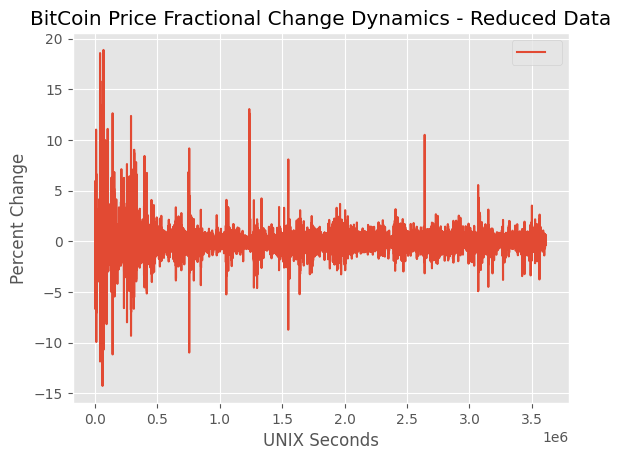

In [223]:
ax = (100*(df_reduced["Close"] - df_reduced["Open"])/df_reduced["Open"])[training_and_display_index:].plot(legend=True)
ax.set_ylabel("Percent Change")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Fractional Change Dynamics - Reduced Data")

Average Fractional Change: 0.08311941199060553%
0.001


Text(0, 0.5, 'Number of Occurances')

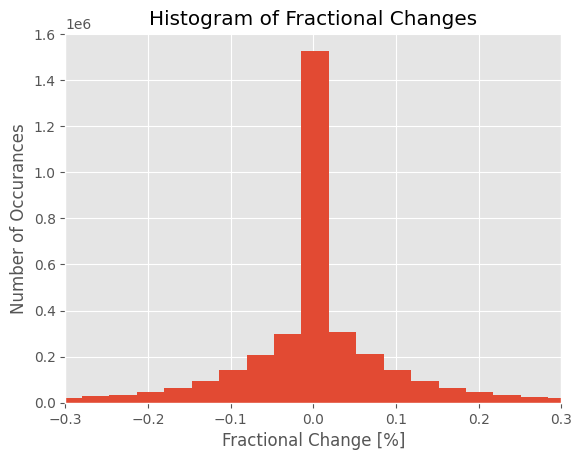

In [224]:
a = (100*(df_reduced["Close"] - df_reduced["Open"])/df_reduced["Open"])[training_and_display_index:]
print(f"Average Fractional Change: {np.mean(np.abs(a))}%")
print(1e-3)
ax = a.hist(bins=1000)
ax.set_xlim(-0.3,0.3)
ax.set_title("Histogram of Fractional Changes")
ax.set_xlabel("Fractional Change [%]")
ax.set_ylabel("Number of Occurances")

Text(0.5, 1.0, 'BTC Prices - ~ Final Year - Reduced Data')

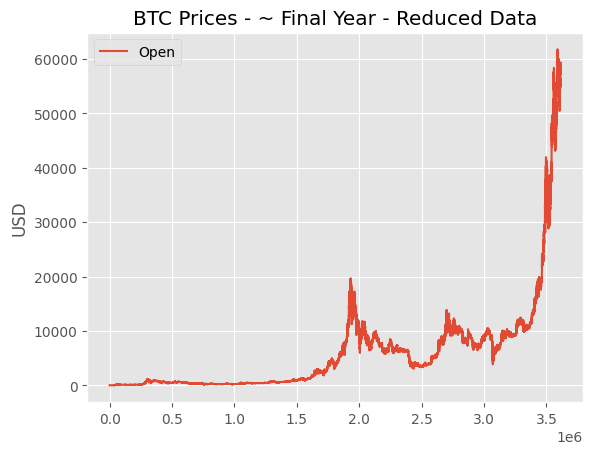

In [225]:
ax = df_reduced["Open"][training_and_display_index:].plot(legend=True)
# df_reduced["High"][-500000:].plot(axes=ax, legend=True)
# df_reduced["Low"][-500000:].plot(axes=ax, legend=True)
# df_reduced["Close"][-500000:].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_title("BTC Prices - ~ Final Year - Reduced Data")

Average Fractional Change: 0.1189190575%
Log
[-1.00000000e-02 -4.39397056e-03 -1.93069773e-03 -8.48342898e-04
 -3.72759372e-04 -1.63789371e-04 -7.19685673e-05 -3.16227766e-05
 -1.38949549e-05 -6.10540230e-06 -2.68269580e-06 -1.17876863e-06
 -5.17947468e-07 -2.27584593e-07 -1.00000000e-07  1.00000000e-07
  2.27584593e-07  5.17947468e-07  1.17876863e-06  2.68269580e-06
  6.10540230e-06  1.38949549e-05  3.16227766e-05  7.19685673e-05
  1.63789371e-04  3.72759372e-04  8.48342898e-04  1.93069773e-03
  4.39397056e-03  1.00000000e-02]
Lin
[-0.01       -0.00931034 -0.00862069 -0.00793103 -0.00724138 -0.00655172
 -0.00586207 -0.00517241 -0.00448276 -0.0037931  -0.00310345 -0.00241379
 -0.00172414 -0.00103448 -0.00034483  0.00034483  0.00103448  0.00172414
  0.00241379  0.00310345  0.0037931   0.00448276  0.00517241  0.00586207
  0.00655172  0.00724138  0.00793103  0.00862069  0.00931034  0.01      ]


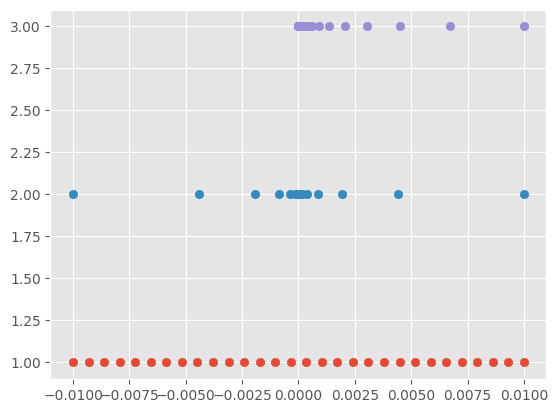

In [226]:
gp = 0.01 # generic percentage change
num = 30
start = 1e-7
frac_change_range_lin = np.linspace(-gp, gp, num)
frac_change_range_log_pos = np.geomspace(start, gp, num//2)
frac_change_range_log_neg = np.flip(-frac_change_range_log_pos, axis=0)
frac_change_range_log = np.concatenate((frac_change_range_log_neg, frac_change_range_log_pos))

# High

frac_high_range_log = np.geomspace(start, gp, num)
print(f"Average Fractional Change: {(100*np.mean(np.abs(frac_change_range_log))):.10f}%")
print("Log")
print(frac_change_range_log)
print("Lin")
print(frac_change_range_lin)
y_lin = np.ones((num,))
y_log = 2*np.ones((num,))

fig, ax = plt.subplots()
ax.scatter(frac_change_range_lin, y_lin)
ax.scatter(frac_change_range_log, y_log)
ax.scatter(frac_high_range_log, y_log+1)

In [227]:
df_reduced.Timestamp
days = np.array(df_reduced.Timestamp[training_and_display_index:], dtype='datetime64[s]')
print(f"Starting Date: {days[0]} and Ending Date: {days[-1]}")

Starting Date: 2011-12-31T15:50:00 and Ending Date: 2021-03-31T00:00:00


In [228]:
print(df_reduced['Volume_(BTC)'].max())
print(df_reduced['Volume_(Currency)'].max())
print(df_reduced['TimeDelta'].max())

5853.8521659
13900672.407
388380.0


In [229]:
%matplotlib inline
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Supress warning in hmmlearn
warnings.filterwarnings('ignore')
# Change plot style to ggplot (for better and more aesthetic visualisation)
plt.style.use('ggplot')


class BitCoinPricePredictor(object):
    def __init__(self, bitcoin_data, test_size=0.33,
                 n_hidden_states=3, n_latency_trade_windows=10,
                 n_steps_frac_change=10, n_steps_frac_high=10,
                 n_steps_frac_low=10, n_steps_observed=10):
        self._init_logger()

        self.data = bitcoin_data
        self.n_latency_trade_windows = n_latency_trade_windows

        self.hmm = GaussianHMM(n_components=n_hidden_states)

        self._split_train_test_data(test_size)

        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low, n_steps_observed)

    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)

    def _split_train_test_data(self, test_size):
        data = self.data
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)

        self._train_data = _train_data
        self._test_data = test_data

    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])
#         vol_btc = np.array(data['Volume_(BTC)'])
        vol_curr = np.array(data['Volume_(Currency)'])
        time_delta = np.array(data['TimeDelta'])

        # Compute the fraction change in close, high and low prices
        # which would be used as features
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price

        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
#         self._logger.info('>>> Extracting Features')
        feature_vector = BitCoinPricePredictor._extract_features(self._train_data)
#         self._logger.info('Features extraction Completed <<<')

        self.hmm.fit(feature_vector)
    
    def new_fit(self):
#         self._logger.info('>>> Extracting Features')
        feature_vector_train = BitCoinPricePredictor._extract_features(self._train_data)
        feature_vector_test = BitCoinPricePredictor._extract_features(self._test_data)
#         self._logger.info('Features extraction Completed <<<')

        best_score = best_model = None
        n_fits = 5
        np.random.seed(130)
        for idx in range(n_fits):
            model = GaussianHMM(
                n_components=2, random_state=idx,
                init_params='se')  # don't init transition, set it below
            # we need to initialize with random transition matrix probabilities
            # because the default is an even likelihood transition
            # we know transitions are rare (otherwise the casino would get caught!)
            # so let's have an Dirichlet random prior with an alpha value of
            # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
            # of the time
#             model.transmat_ = np.array([np.random.dirichlet([0.5, 0.5]),
#                                         np.random.dirichlet([0.5, 0.5])])
#             model.emissionprob_ = np.array([[0.25,0.25,0.25,0.25],
#                                             [0.25,0.25,0.25,0.25]])
            model.fit(feature_vector_train)
            score = model.score(feature_vector_train)
            print(f'Model #{idx}\tScore: {score}')
            if best_score is None or score > best_score:
                best_model = model
                best_score = score
        self.hmm = model

    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low, n_steps_observed, start = 4e-3, gp = 0.1):
#         gp = 0.1 # generic percentage change
#         start = 4e-3
        # Fractional Change Open to Close
        frac_change_range_log_pos = np.geomspace(start, gp, n_steps_frac_change//2)
        frac_change_range_log_neg = np.flip(-frac_change_range_log_pos, axis=0)
        frac_change_range_log = np.concatenate((frac_change_range_log_neg, frac_change_range_log_pos))
        # Fractional Change High
        frac_high_range_log = np.geomspace(start, gp, n_steps_frac_high)
#         frac_high_range_log_neg = -frac_change_range_log_pos
#         frac_high_range_log = np.concatenate((frac_change_range_log_neg, frac_change_range_log_pos))
        # Fractional Change Low
        frac_low_range_log = np.geomspace(start, gp, n_steps_frac_low)
#         frac_low_range_log_neg = -frac_change_range_log_pos
#         frac_low_range_log = np.concatenate((frac_change_range_log_neg, frac_change_range_log_pos))
#         # Linear Methods
#         frac_change_range = np.linspace(-gp, gp, n_steps_frac_change)
#         frac_high_range = np.linspace(0, gp, n_steps_frac_high)
#         frac_low_range = np.linspace(0, gp, n_steps_frac_low)
#         open_max = self._train_data['Open'].max()
#         open_range = np.linspace(0, open_max, n_steps_observed)
#         close_max = self._train_data['Close'].max()
#         close_range = np.linspace(0, close_max, n_steps_observed)
#         vol_btc_max = self._train_data['Volume_(BTC)'].max()
#         vol_btc_range = np.linspace(0, vol_BTC_max, n_steps_observed)
        vol_curr_max = self._train_data['Volume_(Currency)'].max()
        vol_curr_range = np.geomspace(start, vol_curr_max, n_steps_observed)
        time_delta_max = self._train_data['TimeDelta'].max()
        time_delta_range = np.geomspace(start, time_delta_max, n_steps_observed)
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range_log, frac_high_range_log, frac_low_range_log)))
#         print(self._possible_outcomes)
        
    def _get_most_probable_outcome(self, trade_window_index):
        previous_data_start_index = max(0, trade_window_index - self.n_latency_trade_windows)
        previous_data_end_index = max(0, trade_window_index - 1)
        previous_data = self._test_data.iloc[previous_data_start_index: previous_data_end_index]
        previous_data_features = BitCoinPricePredictor._extract_features(
            previous_data)        

        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
        #print(np.argmax(outcome_score))

        #print(most_probable_outcome)
        
        return most_probable_outcome

    def predict_frac_change(self, trade_window_index):
        open_price = self._test_data.iloc[trade_window_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(trade_window_index)
#         print(f"Open Price: {open_price}")
#         print(f"Frac Change: {predicted_frac_change}")
#         print(f"Close Price: {open_price * (1 + predicted_frac_change)}")
        
        return predicted_frac_change
    
    def predict_close_price(self, trade_window_index):
        open_price = self._test_data.iloc[trade_window_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(trade_window_index)
#         print(f"Open Price: {open_price}")
#         print(f"Frac Change: {predicted_frac_change}")
#         print(f"Close Price: {open_price * (1 + predicted_frac_change)}")
#         print(f"Predicted Close Price: {predicted_close_price}")
        
        return open_price * (1 + predicted_frac_change)

    def predict_frac_changes_for_trade_windows(self, trade_windows, with_plot=False):
        predicted_frac_changes = []
        for trade_window_index in tqdm(range(trade_windows)):
            predicted_frac_changes.append(self.predict_frac_change(trade_window_index))
        predicted_frac_changes = np.array(predicted_frac_changes)

        if with_plot:
            test_data = self._test_data[0: trade_windows]
            days = np.array(test_data.Timestamp, dtype='datetime64[s]')
            actual_open_prices = test_data['Open']
            actual_close_prices = test_data['Close']

            fig = plt.figure()

            axes = fig.add_subplot(111)
            actual_frac_changes = (actual_close_prices - actual_open_prices) / actual_open_prices
            axes.plot(days, actual_frac_changes, 'bo-', label='actual')
            axes.plot(days, predicted_frac_changes, 'r+-', label='predicted')
            axes.set_ylabel("Fractional Change Open-to-Close")
            
            fig.autofmt_xdate()

            plt.legend()
            plt.show()
            
            MSE = 1/np.size(actual_frac_changes)*np.linalg.norm(actual_frac_changes-predicted_frac_changes, ord=2)**2

        return predicted_frac_changes, MSE
    
    def predict_close_prices_for_trade_windows(self, trade_windows, with_plot=False):
        predicted_close_prices = []
        for trade_window_index in tqdm(range(trade_windows)):
            predicted_close_prices.append(self.predict_close_price(trade_window_index))

        if with_plot:
            test_data = self._test_data[0: trade_windows]
            print(test_data)
            days = np.array(test_data.Timestamp, dtype='datetime64[s]')
            actual_close_prices = test_data['Close']
            actual_open_prices = test_data['Open']
            actual_high_prices = test_data['High']
            actual_low_prices = test_data['Low']

            fig = plt.figure()

            axes = fig.add_subplot(111)
#             axes.plot(days, actual_open_prices, 'go-', label='actual_open')
#             axes.plot(days, actual_high_prices, 'yo-', label='actual_high')
#             axes.plot(days, actual_low_prices, 'mo-', label='actual_low')
            axes.plot(days, actual_close_prices, 'bo-', label='actual_close')
            axes.plot(days, predicted_close_prices, 'r+-', label='predicted')
            axes.set_ylabel("BTC Value [USD]")
            
            fig.autofmt_xdate()

            plt.legend()
            plt.show()
            
            MSE = 1/np.size(actual_close_prices)*np.linalg.norm(actual_close_prices-predicted_close_prices, ord=2)**2

        return predicted_close_prices, MSE


btc_predictor = BitCoinPricePredictor(df_reduced[training_and_display_index:],n_latency_trade_windows=10)
btc_predictor.new_fit()
print("Fitting Done - Proceed to next cell for predictions")

Model #0	Score: 38547545.440769754
Model #1	Score: 36535515.65154931
Model #2	Score: 37312227.64810428
Model #3	Score: 40891812.4060783
Model #4	Score: 40548756.976320975
Fitting Done - Proceed to next cell for predictions


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.48it/s]


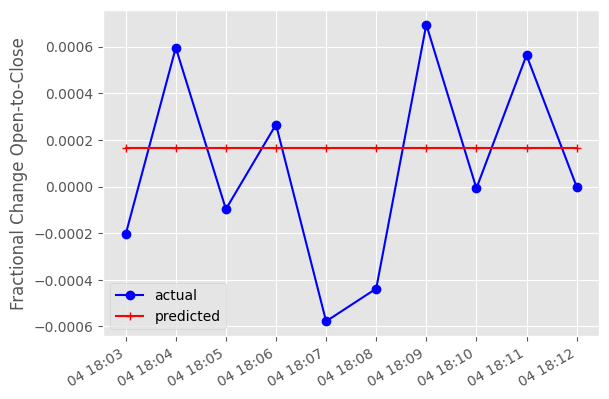

MSE: 1.8101478128566145e-07
Predicted Fractional Changes:
 [0.00016379 0.00016379 0.00016379 0.00016379 0.00016379 0.00016379
 0.00016379 0.00016379 0.00016379 0.00016379]


In [230]:
num = 4
btc_predictor._compute_all_possible_outcomes(n_steps_frac_change=30,
                                       n_steps_frac_high=num, n_steps_frac_low=num, 
                                             n_steps_observed=num, start = 1e-7, gp = 0.01)
predicted_frac_changes, MSE = btc_predictor.predict_frac_changes_for_trade_windows(10, with_plot=True)
print(f"MSE: {MSE}")
print(f"Predicted Fractional Changes:\n {predicted_frac_changes}")

100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]

          Timestamp      Open      High       Low     Close  Volume_(BTC)  \
3580765  1615164780  51391.67  51445.48  51299.31  51431.59      7.137935   
3580766  1615164840  51437.02  51554.12  51437.02  51540.02      1.308899   
3580767  1615164900  51536.03  51581.31  51528.08  51530.35      0.248576   
3580768  1615164960  51551.36  51552.85  51488.13  51537.79      1.620598   
3580769  1615165020  51531.23  51563.30  51506.55  51525.25      1.583173   
3580770  1615165080  51528.23  51579.81  51528.23  51528.23      5.599644   
3580771  1615165140  51535.01  51535.01  51379.74  51480.40      1.398680   
3580772  1615165200  51489.45  51538.57  51454.67  51507.99      0.933526   
3580773  1615165260  51519.98  51519.98  51400.31  51400.31      0.911284   
3580774  1615165320  51416.61  51468.06  51416.61  51462.45      0.690570   

         Volume_(Currency)  Weighted_Price  TimeDelta  
3580765      366410.183490    51332.799911       60.0  
3580766       67419.559075    51508.6050

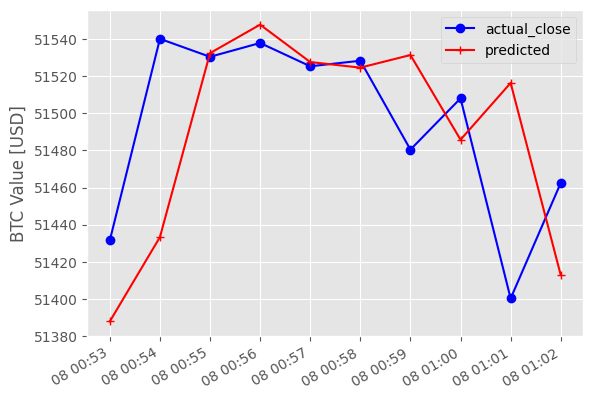

MSE: 3239.5146121091125


In [189]:
predicted_frac_changes, MSE = btc_predictor.predict_close_prices_for_trade_windows(10, with_plot=True)
print(f"MSE: {MSE}")
# TO-DO: Look how the predicted fractional changes are practically zero. As a result, we would expect to see 
# the predicted value for each day equal to the actual close value from the previous day, but we do not. 
# Why is that? Try to print out the last two or three rows of the the optimal sequence and compare to actual
# close values. Make sure the sequences being evaluated are using good data!...